In [1]:
%pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   -------------- ------------------------- 20.2/56.8 MB 102.8 MB/s eta 0:00:01
   -------------------------- ------------- 37.7/56.8 MB 95.3 MB/s eta 0:00:01
   ---------------------------------------  55.8/56.8 MB 91.1 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 77.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, glob, zipfile, io, warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd, time
import matplotlib.pyplot as plt
import time

from collections import Counter
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import log_loss, accuracy_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from scipy import sparse
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import sparse
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


# Try fast gradient-boosting libs
xgb_available, lgb_available = False, False
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    try:
        from lightgbm import LGBMClassifier
        lgb_available = True
    except Exception:
        pass

In [4]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
DATA_DIR  = "C:/python_src2/data/San-Francisco-Crime.csv"

# Load
train = pd.read_csv(DATA_DIR)
assert "Category" in train.columns
assert {"Dates","DayOfWeek","PdDistrict","X","Y"}.issubset(train.columns)
print("Train", train.shape)

Train (878049, 9)



=== EDA: structure & nulls ===
Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object
Dates         0.0
Category      0.0
Descript      0.0
DayOfWeek     0.0
PdDistrict    0.0
Resolution    0.0
Address       0.0
X             0.0
Y             0.0
dtype: float64


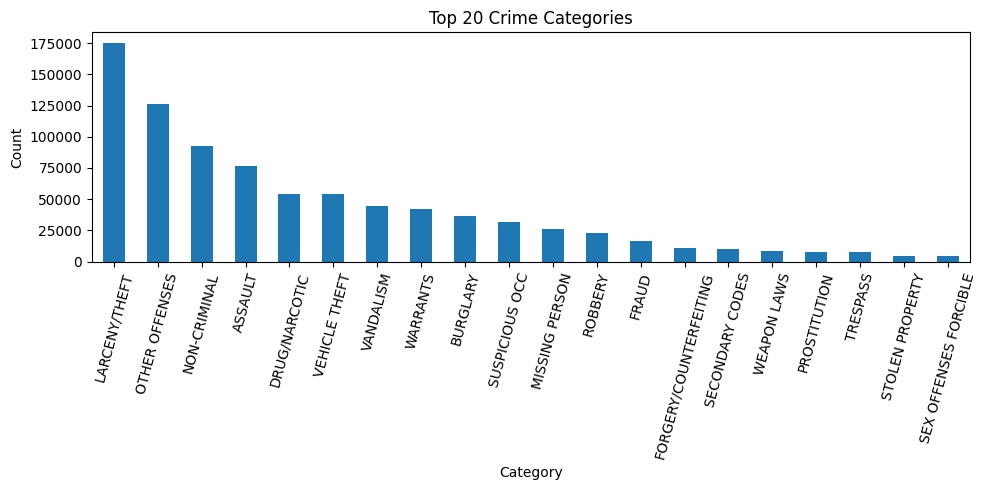

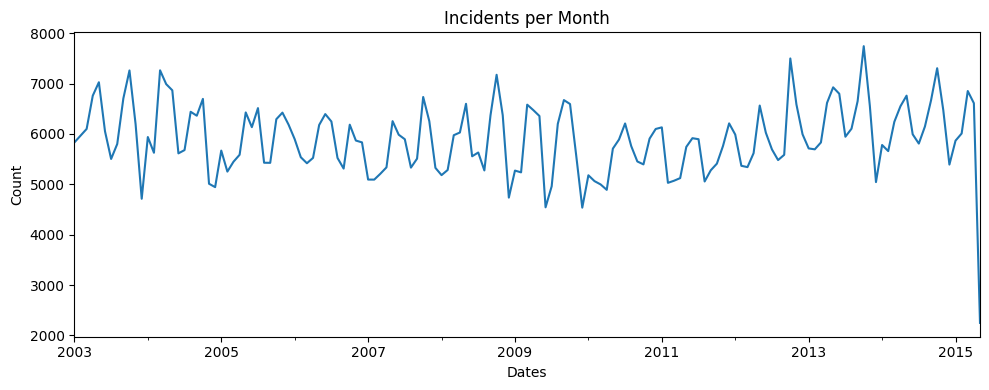

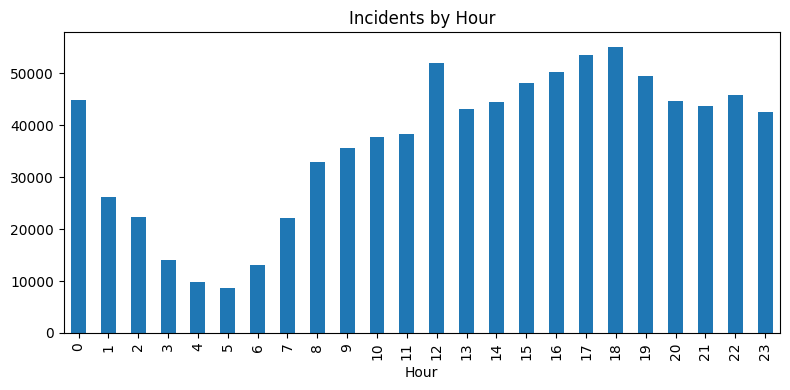

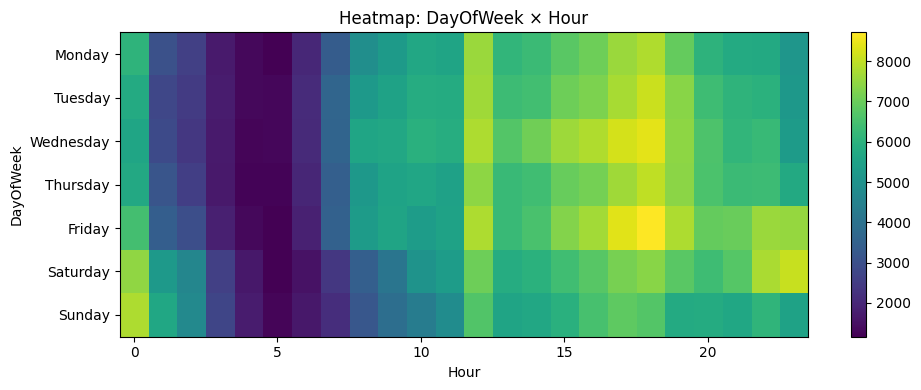

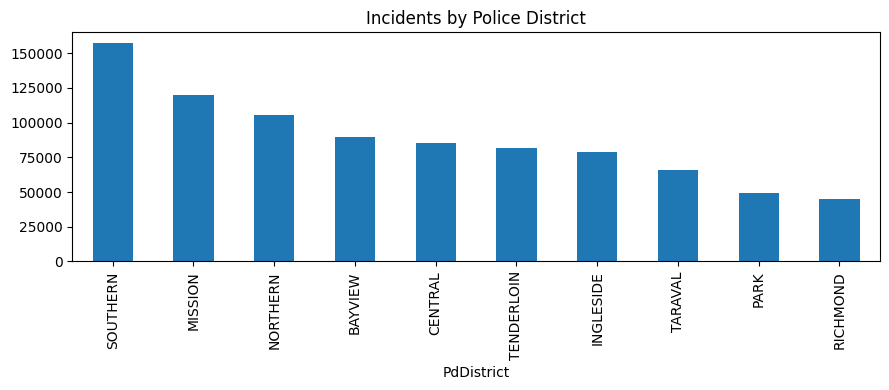

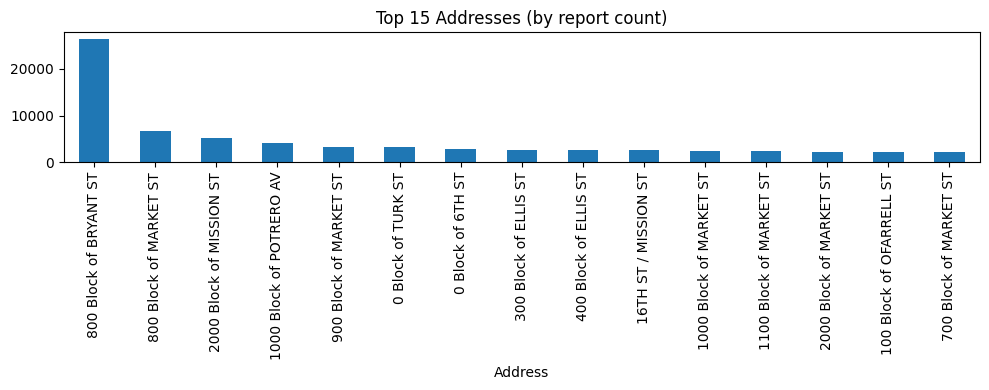

In [5]:
def eda(train):
    print("\n=== EDA: structure & nulls ===")
    print(train.dtypes)
    print(train.isna().mean().sort_values(ascending=False).head(10))

    # Top categories
    plt.figure(figsize=(10,5))
    train['Category'].value_counts().head(20).plot(kind='bar')
    plt.title("Top 20 Crime Categories"); plt.ylabel("Count"); plt.xticks(rotation=75)
    plt.tight_layout(); plt.show()

    # Monthly trend
    dt = pd.to_datetime(train['Dates'])
    monthly = train.groupby([dt.dt.to_period('M')]).size().rename("count").to_timestamp()
    plt.figure(figsize=(10,4))
    monthly.plot()
    plt.title("Incidents per Month"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

    # Hour-of-day
    plt.figure(figsize=(8,4))
    dt.dt.hour.value_counts().sort_index().plot(kind='bar')
    plt.title("Incidents by Hour"); plt.xlabel("Hour"); plt.tight_layout(); plt.show()

    # Heatmap: DayOfWeek vs Hour
    dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    pivot = pd.crosstab(train['DayOfWeek'], dt.dt.hour)
    pivot = pivot.reindex(dow_order)
    plt.figure(figsize=(10,4))
    plt.imshow(pivot.values, aspect='auto', interpolation='nearest')
    plt.title("Heatmap: DayOfWeek × Hour"); plt.xlabel("Hour"); plt.ylabel("DayOfWeek")
    plt.colorbar()
    plt.yticks(range(len(dow_order)), dow_order)
    plt.tight_layout(); plt.show()

    # District counts
    plt.figure(figsize=(9,4))
    train['PdDistrict'].value_counts().plot(kind='bar')
    plt.title("Incidents by Police District"); plt.tight_layout(); plt.show()

    # Top addresses 
    plt.figure(figsize=(10,4))
    train['Address'].value_counts().head(15).plot(kind='bar')
    plt.title("Top 15 Addresses (by report count)"); plt.tight_layout(); plt.show()


eda(train)

In [8]:
def feature_engineer(df):
    out = df.copy()
    dt = pd.to_datetime(out['Dates'])
    out['Year']   = dt.dt.year.astype(np.int16)
    out['Month']  = dt.dt.month.astype(np.int8)
    out['Day']    = dt.dt.day.astype(np.int8)
    out['Hour']   = dt.dt.hour.astype(np.int8)
    out['Minute'] = dt.dt.minute.astype(np.int8)
    out['IsWeekend'] = (dt.dt.dayofweek >= 5).astype(np.int8)

    # Cyclic encodings
    out['sin_hour'] = np.sin(2*np.pi*out['Hour']/24.0).astype(np.float32)
    out['cos_hour'] = np.cos(2*np.pi*out['Hour']/24.0).astype(np.float32)
    dow_map = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}
    out['DOW_idx'] = out['DayOfWeek'].map(dow_map).astype(np.int8)
    out['sin_dow'] = np.sin(2*np.pi*out['DOW_idx']/7.0).astype(np.float32)
    out['cos_dow'] = np.cos(2*np.pi*out['DOW_idx']/7.0).astype(np.float32)

    # Address flags
    addr = out['Address'].fillna("")
    out['IsIntersection'] = addr.str.contains("/", regex=False).astype(np.int8)
    out['HasBlockWord']   = addr.str.contains("Block", case=False, regex=False).astype(np.int8)

    # Simple geo 
    dx = (out['X'] + 122.4194) * (111.0*np.cos(np.deg2rad(37.77)))  # ~km per lon degree at SF
    dy = (out['Y'] - 37.7749) * 111.0                               # km per lat degree
    out['dist_km_center'] = np.sqrt(dx*dx + dy*dy).astype(np.float32)

    # Rounding for coarse grids
    out['X_round2'] = out['X'].round(2).astype(np.float32)
    out['Y_round2'] = out['Y'].round(2).astype(np.float32)

    return out

train_fe = feature_engineer(train)

# Target
le = LabelEncoder()
y = le.fit_transform(train_fe['Category'])
class_names = list(le.classes_)
n_classes = len(class_names)
print("Classes:", n_classes)

# Columns
categorical_cols = ['DayOfWeek', 'PdDistrict', 'IsWeekend', 'IsIntersection', 'HasBlockWord']
numeric_cols = [
    'Year','Month','Day','Hour','Minute',
    'sin_hour','cos_hour','DOW_idx','sin_dow','cos_dow',
    'X','Y','dist_km_center','X_round2','Y_round2'
]

# Train/validation split
X_df = train_fe[categorical_cols + numeric_cols]
X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_df, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


# Manual preprocessing
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train_df[categorical_cols])
Xtr_cat = ohe.transform(X_train_df[categorical_cols])
Xva_cat = ohe.transform(X_val_df[categorical_cols])

# Scale numeric
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train_df[numeric_cols])
Xtr_num = scaler.transform(X_train_df[numeric_cols]).astype(np.float32)
Xva_num = scaler.transform(X_val_df[numeric_cols]).astype(np.float32)

#  Concatenate
X_train = np.hstack([Xtr_cat, Xtr_num]).astype(np.float32)
X_val   = np.hstack([Xva_cat, Xva_num]).astype(np.float32)

# Feature
try:
    ohe_names = ohe.get_feature_names_out(categorical_cols)
except Exception:
    ohe_names = []
    for i, cats in enumerate(ohe.categories_):
        base = categorical_cols[i]
        ohe_names += [f"{base}={c}" for c in cats]
feature_names = np.array(list(ohe_names) + numeric_cols)

print("Design matrices:", X_train.shape, X_val.shape )

Classes: 39
Design matrices: (702439, 38) (175610, 38)


In [9]:
def per_class_accuracy(y_true, proba, top_k=15):
    pred = proba.argmax(1)
    accs = []
    counts = Counter(y_true)
    for c, cnt in counts.most_common(top_k):
        mask = (y_true == c)
        accs.append((class_names[c], cnt, (pred[mask] == c).mean()))
    return pd.DataFrame(accs, columns=["Class","Count","Accuracy"]).sort_values("Accuracy", ascending=False)

def plot_top1_reliability(proba, y_true, title, n_bins=15):
    conf = proba.max(axis=1)
    pred = proba.argmax(axis=1)
    correct = (pred == y_true).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    xs, ys = [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (conf >= lo) & (conf < hi if i < n_bins - 1 else conf <= hi)
        if np.any(m):
            xs.append(conf[m].mean()); ys.append(correct[m].mean())
    plt.figure(figsize=(6,5))
    plt.plot(xs, ys, marker='o'); plt.plot([0,1],[0,1],'--')
    plt.title(title); plt.xlabel("Mean confidence (top-1 p)"); plt.ylabel("Empirical accuracy")
    plt.tight_layout(); plt.show()

def expected_calibration_error(y_true, proba, n_bins=15):
    conf = proba.max(axis=1); pred = proba.argmax(axis=1)
    correct = (pred == y_true).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece, signed = 0.0, 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (conf >= lo) & (conf < hi if i < n_bins - 1 else conf <= hi)
        if np.any(m):
            acc = correct[m].mean(); c = conf[m].mean(); w = m.mean()
            ece += w * abs(acc - c); signed += w * (acc - c)
    return ece, signed

def plot_importances(estimator, feature_names, title, top_n=20):
    imps = getattr(estimator, "feature_importances_", None)
    if imps is None:
        print(f"{title}: no tree importances available."); return
    df = pd.DataFrame({"feature": feature_names, "importance": imps})
    df = df.sort_values("importance", ascending=False).head(top_n)
    plt.figure(figsize=(8, max(4, 0.35*top_n)))
    plt.barh(df.iloc[::-1]['feature'], df.iloc[::-1]['importance'])
    plt.title(title); plt.xlabel("Importance"); plt.tight_layout(); plt.show()

def svm_weight_table(calibrated_svm, feature_names, top_n=20):
    coefs = []
    for cc in calibrated_svm.calibrated_classifiers_:
        est = getattr(cc, "estimator", getattr(cc, "base_estimator", None))
        coef = getattr(est, "coef_", None)
        if coef is not None:
            coefs.append(coef.ravel())
    if not coefs:
        return None
    coefs = np.vstack(coefs)
    mean_abs = np.mean(np.abs(coefs), axis=0)
    df = pd.DataFrame({"feature": feature_names, "mean_abs_coef": mean_abs})
    return df.sort_values("mean_abs_coef", ascending=False).head(top_n)


MODEL 1 — Random Forest
RF log-loss: 2.59944 | top-1 acc: 0.2487


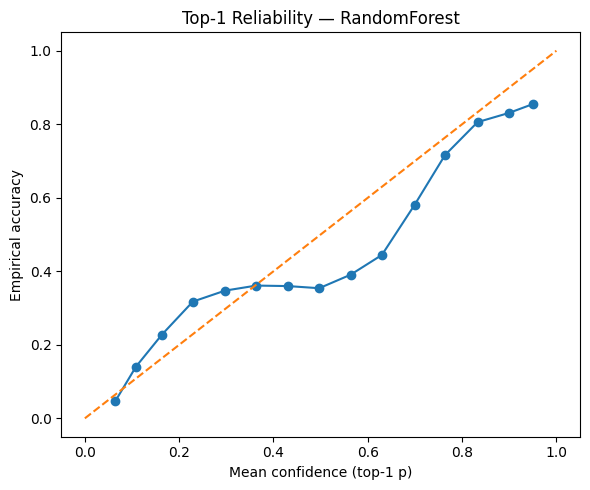

RF ECE: 0.0581 | bias=+0.0419 → under-confident


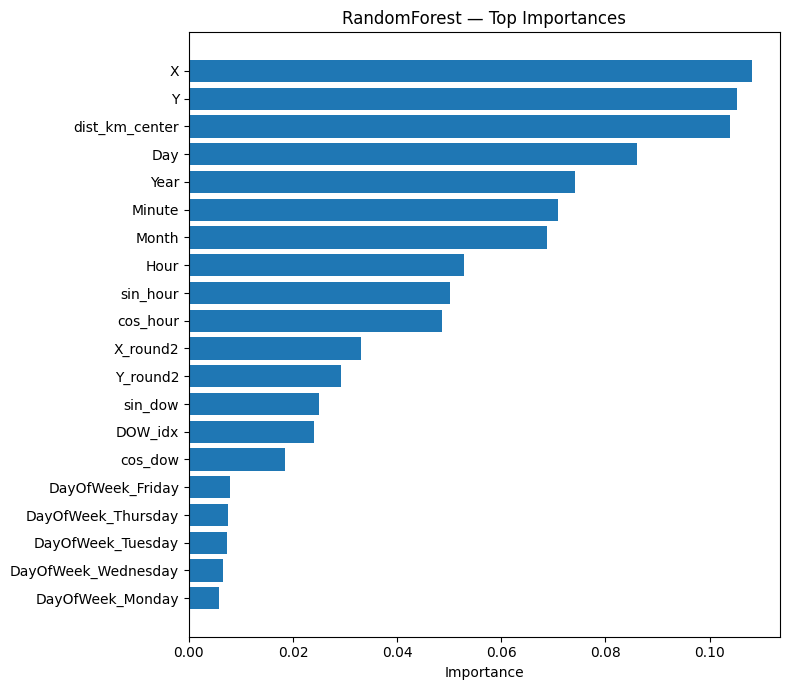

RandomForest — Per-class accuracy (top 15 by support):


,Class,Count,Accuracy
10,MISSING PERSON,5198,0.550596
4,DRUG/NARCOTIC,10794,0.541319
5,VEHICLE THEFT,10756,0.487821
0,LARCENY/THEFT,34980,0.320354
8,BURGLARY,7351,0.312202
13,FORGERY/COUNTERFEITING,2122,0.280867
1,OTHER OFFENSES,25236,0.217309
12,FRAUD,3336,0.156775
2,NON-CRIMINAL,18461,0.131791
11,ROBBERY,4600,0.129565


In [10]:
print("\n" + "="*60)
print("MODEL 1 — Random Forest")
rf = RandomForestClassifier(
    n_estimators=400,           
    max_depth=30,              
    min_samples_leaf=5,
    n_jobs=-1,
    class_weight='balanced_subsample',
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_val)
rf_ll  = log_loss(y_val, rf_proba, labels=np.arange(n_classes))
rf_acc = accuracy_score(y_val, rf_proba.argmax(1))
print(f"RF log-loss: {rf_ll:.5f} | top-1 acc: {rf_acc:.4f}")

plot_top1_reliability(rf_proba, y_val, "Top-1 Reliability — RandomForest", n_bins=15)
ece, signed = expected_calibration_error(y_val, rf_proba, 15)
trend = "under-confident" if signed>0 else ("over-confident" if signed<0 else "well-calibrated")
print(f"RF ECE: {ece:.4f} | bias={signed:+.4f} → {trend}")

plot_importances(rf, feature_names, "RandomForest — Top Importances", top_n=20)
rf_pc = per_class_accuracy(y_val, rf_proba, top_k=15)
print("RandomForest — Per-class accuracy (top 15 by support):")
display(rf_pc)

In [14]:
%pip install collection

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for collection: filename=collection-0.1.6-py3-none-any.whl size=5154 sha256=036d05c99be2daa412024885b9a6043a9d89d7854eac0516ff74351dbf0b18d2
  Stored in directory: c:\users\playdata2\appdata\local\pip\cache\wheels\44\4e\bc\c84bc8b82a0f294305b47c7ff1ffcda2e15cc9ca2b175ba674
Successfully built collection
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from collections import Counter
Counter(y_train)

In [ ]:
print("\n" + "="*60)
print("MODEL 2 — XGBoost")
if xgb_available:
    gb_name = "XGBoost"
    gb_xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=n_classes,
        # tree_method='gpu_hist',
        # predictor= 'gpu_predictor',
        max_depth=8,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=300,      
        reg_lambda=1.0,
        reg_alpha=0.0,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
        eval_metric='mlogloss'
    )
    gb_xgb.fit(X_train, y_train)
    gb_proba_xgb = gb_xgb.predict_proba(X_val)
    gb_ll_xgb  = log_loss(y_val, gb_proba_xgb, labels=np.arange(n_classes))
    gb_acc_xgb = accuracy_score(y_val, gb_proba_xgb.argmax(1))
    print(f"{gb_name} log-loss: {gb_ll_xgb:.5f} | top-1 acc: {gb_acc_xgb:.4f}")

    plot_top1_reliability(gb_proba_xgb, y_val, f"Top-1 Reliability — {gb_name}", n_bins=15)
    ece, signed = expected_calibration_error(y_val, gb_proba_xgb, 15)
    trend = "under-confident" if signed>0 else ("over-confident" if signed<0 else "well-calibrated")
    print(f"{gb_name} ECE: {ece:.4f} | bias={signed:+.4f} → {trend}")

    plot_importances(gb_xgb, feature_names, f"{gb_name} — Top Importances", top_n=20)
    gb_pc_xgb = per_class_accuracy(y_val, gb_proba_xgb, top_k=15)
    print(f"{gb_name} — Per-class accuracy (top 15 by support):")
    display(gb_pc_xgb)
else:
    print("XGBoost not available; skipping this block.")


MODEL 2 — XGBoost


In [19]:
def _softmax_rows(scores):
    z = scores - scores.max(axis=1, keepdims=True)
    p = np.exp(z); p /= p.sum(axis=1, keepdims=True)
    return np.clip(p, 1e-15, 1-1e-15)

def _pick_temperature(margins, y_true, n_classes, grid=(0.5, 0.7, 1.0, 1.4, 2.0, 3.0, 5.0, 8.0)):
    best_ll, best_T = 1e9, 1.0
    for T in grid:
        ll = log_loss(y_true, _softmax_rows(margins / T), labels=np.arange(n_classes))
        if ll < best_ll:
            best_ll, best_T = ll, T
    return best_T, best_ll

assert 'train_fe' in globals(), "Run your feature_engineer() block first to create train_fe."

districts = sorted(train_fe['PdDistrict'].dropna().unique().tolist())
rows = []

for dist in districts:
    df_d = train_fe.loc[train_fe['PdDistrict'] == dist].copy()
    if df_d.empty:
        continue

    # Ensure stratified split validity
    vc = df_d['Category'].value_counts()
    keep = vc[vc >= 2].index
    df_d = df_d[df_d['Category'].isin(keep)]
    if df_d['Category'].nunique() < 2:
        print(f"[skip] {dist}: <2 classes after filtering singletons")
        continue

    # Labels within district
    le_d = LabelEncoder().fit(df_d['Category'])
    y_d  = le_d.transform(df_d['Category'])
    Kd   = le_d.classes_.size

    # Features for this district (NO PdDistrict — it’s fixed within the loop)
    cat_cols_d = ['DayOfWeek','IsWeekend','IsIntersection','HasBlockWord']
    num_cols_d = [
        'Year','Month','Day','Hour','Minute',
        'sin_hour','cos_hour','sin_dow','cos_dow',
        'DOW_idx','X','Y','X_round2','Y_round2','dist_km_center'
    ]

    ohe_d = OneHotEncoder(handle_unknown='ignore', sparse_output=True).fit(df_d[cat_cols_d])
    Xc = ohe_d.transform(df_d[cat_cols_d])

    sc_d  = StandardScaler(with_mean=False, with_std=True).fit(df_d[num_cols_d])
    Xn = sc_d.transform(df_d[num_cols_d])

    Xd = sparse.hstack([Xc, Xn], format="csr")

    # Strict stratified split 
    Xtr, Xva, ytr, yva = train_test_split(
        Xd, y_d, test_size=0.2, stratify=y_d, random_state=RANDOM_STATE
    )

    # Linear SVM (OvR)
    base_linear = LinearSVC(
        C=0.5,
        loss='squared_hinge',
        tol=1e-3,
        max_iter=6000,
        class_weight='balanced',
        dual=False,
        random_state=RANDOM_STATE
    )
    clf = OneVsRestClassifier(base_linear, n_jobs=-1)

    t0 = time.time()
    clf.fit(Xtr, ytr)
    train_secs = time.time() - t0

    # Accuracy on validation
    acc = accuracy_score(yva, clf.predict(Xva))

    # Temperature-scaled log-loss 

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_STATE)
    cal_idx, _ = next(sss.split(Xtr, ytr))
    marg_cal = clf.decision_function(Xtr[cal_idx])  # [n_cal, Kd]
    T, cal_ll = _pick_temperature(marg_cal, ytr[cal_idx], Kd)

    # Evaluate LL on validation margins at temperature T
    marg_val = clf.decision_function(Xva)          # [n_val, Kd]
    proba_va = _softmax_rows(marg_val / T)
    ll_val   = log_loss(yva, proba_va, labels=np.arange(Kd))

    rows.append([dist, len(df_d), Kd, acc, ll_val, T, train_secs])

per_dist_ll = pd.DataFrame(
    rows, columns=["PdDistrict","n_rows","n_classes","val_acc","val_logloss","temp_T","train_time_s"]
).sort_values("val_acc", ascending=False)

print("\nPer-district LinearSVC (OvR) — validation (with log-loss; top 10 by accuracy):")
print(per_dist_ll.head(10).to_string(index=False))


Per-district LinearSVC (OvR) — validation (with log-loss; top 10 by accuracy):
PdDistrict  n_rows  n_classes  val_acc  val_logloss  temp_T  train_time_s
   BAYVIEW   89431         39 0.075250     3.388598     0.5     59.263550
      PARK   49312         36 0.073507     3.282482     0.7     28.777900
 INGLESIDE   78845         37 0.067791     3.430801     0.5     45.412888
   MISSION  119907         38 0.067259     3.389234     0.5     57.350665
  NORTHERN  105295         38 0.065340     3.354813     0.7     58.397409
TENDERLOIN   81808         37 0.062462     3.329105     0.7     45.204331
   CENTRAL   85459         38 0.052130     3.401323     0.7     37.781786
   TARAVAL   65596         38 0.047180     3.406737     0.7     32.932464
  RICHMOND   45208         37 0.046782     3.362333     0.7     34.217160
  SOUTHERN  157182         38 0.041575     3.439175     0.7     96.299554


In [ ]:
RANDOM_STATE = 42

# Safety checks
for v in ["X_train","y_train","X_val","y_val","n_classes"]:
    assert v in globals(), f"Missing {v}. Run your feature block first."

def _softmax_rows(scores: np.ndarray) -> np.ndarray:
    z = scores - scores.max(axis=1, keepdims=True)
    p = np.exp(z); p /= p.sum(axis=1, keepdims=True)
    return np.clip(p, 1e-15, 1 - 1e-15)

def _pick_temperature(margins, y_true, n_classes, grid=(0.5, 0.7, 1.0, 1.4, 2.0, 3.0, 5.0, 8.0)):
    best_ll, best_T = 1e9, 1.0
    for T in grid:
        ll = log_loss(y_true, _softmax_rows(margins / T), labels=np.arange(n_classes))
        if ll < best_ll:
            best_ll, best_T = ll, T
    return best_T, best_ll

print("\n" + "="*60)
print("GLOBAL SVM — OvR (SGD hinge) on FULL data")

# Train linear SVM (OvR)
t0 = time.time()
svm_ovr = SGDClassifier(
    loss="hinge",       
    alpha=1e-4,
    max_iter=15,            
    tol=1e-3,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
svm_ovr.fit(X_train, y_train)
t1 = time.time()

# Accuracy
y_pred = svm_ovr.predict(X_val)
acc = accuracy_score(y_val, y_pred)

# Temperature-scaled log-loss
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_STATE)
cal_idx, _ = next(sss.split(X_train, y_train))
marg_cal = svm_ovr.decision_function(X_train[cal_idx])
T, cal_ll = _pick_temperature(marg_cal, y_train[cal_idx], n_classes)

marg_val = svm_ovr.decision_function(X_val)
proba_val = _softmax_rows(marg_val / T)
ll = log_loss(y_val, proba_val, labels=np.arange(n_classes))

print(f"SVM (OvR, SGD-hinge)  acc={acc:.4f} | log-loss={ll:.5f} | train_time={t1 - t0:.1f}s | T={T} (cal-LL={cal_ll:.5f})")